In [59]:
import random
import string
import json
import xarray as xr
import pandas as pd
import numpy as np
from ntv_numpy import Xdataset
import ntv_pandas as npd
import cbor2
import matplotlib.pyplot as plt

In [68]:
def file_sizes(xnd, forma={}):
    '''calculate the size of each format'''
    df = xnd.to_dataframe(json_name=False, info=False).reset_index().sample(frac=1)
    jsn = xnd.to_json(notype='all', header=False, encoded=False, format=forma)
    return {'pd.to_json(values)': len(df.to_json(orient='values')),
            'pd.to_csv': len(df.to_csv()),
            'pd.to_parquet': len(df.to_parquet(engine='pyarrow')),
            'xnd.to_json': len(json.dumps(jsn)),
            'xnd.to_json(cbor)': len(cbor2.dumps(jsn))}

def sizes_plot(sizes, titles, fig_title):
    '''plot the size of some format''' 
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(fig_title)
    for idx, (size, title) in enumerate(zip(sizes, titles)):
        bar_colors = ['tab:red' if val == min(size.values()) else 'tab:blue' for val in size.values()]
        percent = [str(round(val / list(size.values())[1] * 100, 1)) + ' %' for val in size.values()]
        bar_plt = axs[idx].bar(size.keys(), size.values(), color=bar_colors)
        axs[idx].set_title(title)
        axs[idx].bar_label(bar_plt, percent, label_type='center')
        axs[idx].tick_params(axis='x', rotation=55)
    plt.show()

## 

## tree and multidimensional patterns

Two basic patterns are present in Datasets:

- Tree pattern: A tree is represented in tabular form by a list of paths between each leaf and the node. The columns then represent the levels of the tree.
- Multidimensional pattern: A matrix (or multidimensional data) is represented in tabular form by a column of the values of the matrix and additional columns represent the coordinates of each of the values.

Table 1 presents an example of binary tree.

| Root | level 1 | level 2 |
|------|---------|---------|
| A    | B       | D       |
| A    | B       | E       |
| A    | C       | F       |
| A    | C       | G       |

*Table 1: Tree pattern*

Table 2 presents an example of matrix

| Value | row | col |
|-------|-----|-----|
| 1     | A   | C   |
| 2     | A   | D   |
| 3     | B   | C   |
| 4     | B   | D   |

*Table 2: Multidimensional pattern*

Taking these structures into account leads to significant duplication of data. In the general case, Datasets mix these different structures.

## multidimensional data

In [69]:

def coords_int(val, leng):
    return np.arange(val, val+leng)

def coords_str(leng):
    return np.array([''.join(random.choices(string.ascii_letters, k=12)) for _ in range(leng)])

dimensions = 5    
fields = ['col_' + str(i) for i in range(dimensions)]

nb1 = 4
nb2 = 10
xdss = [xr.Dataset({"var": (fields, np.arange(nb1**5).reshape([nb1] * dimensions))}, coords={field: coords_int(val*nb1, nb1) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, np.arange(nb1**5).reshape([nb1] * dimensions))}, coords={field: coords_str(nb1) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, np.arange(nb2**5).reshape([nb2] * dimensions))}, coords={field: coords_int(val*nb2, nb2) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, np.arange(nb2**5).reshape([nb2] * dimensions))}, coords={field: coords_str(nb2) for val, field in enumerate(fields)})] #,

Xdataset.from_xarray(xdss[2]).to_dataframe(ntv_type=False, info=False).reset_index()

,col_0,col_1,col_2,col_3,col_4,var
0,0,10,20,30,40,0
1,0,10,20,30,41,1
2,0,10,20,30,42,2
3,0,10,20,30,43,3
4,0,10,20,30,44,4
...,...,...,...,...,...,...
99995,9,19,29,39,45,99995
99996,9,19,29,39,46,99996
99997,9,19,29,39,47,99997
99998,9,19,29,39,48,99998


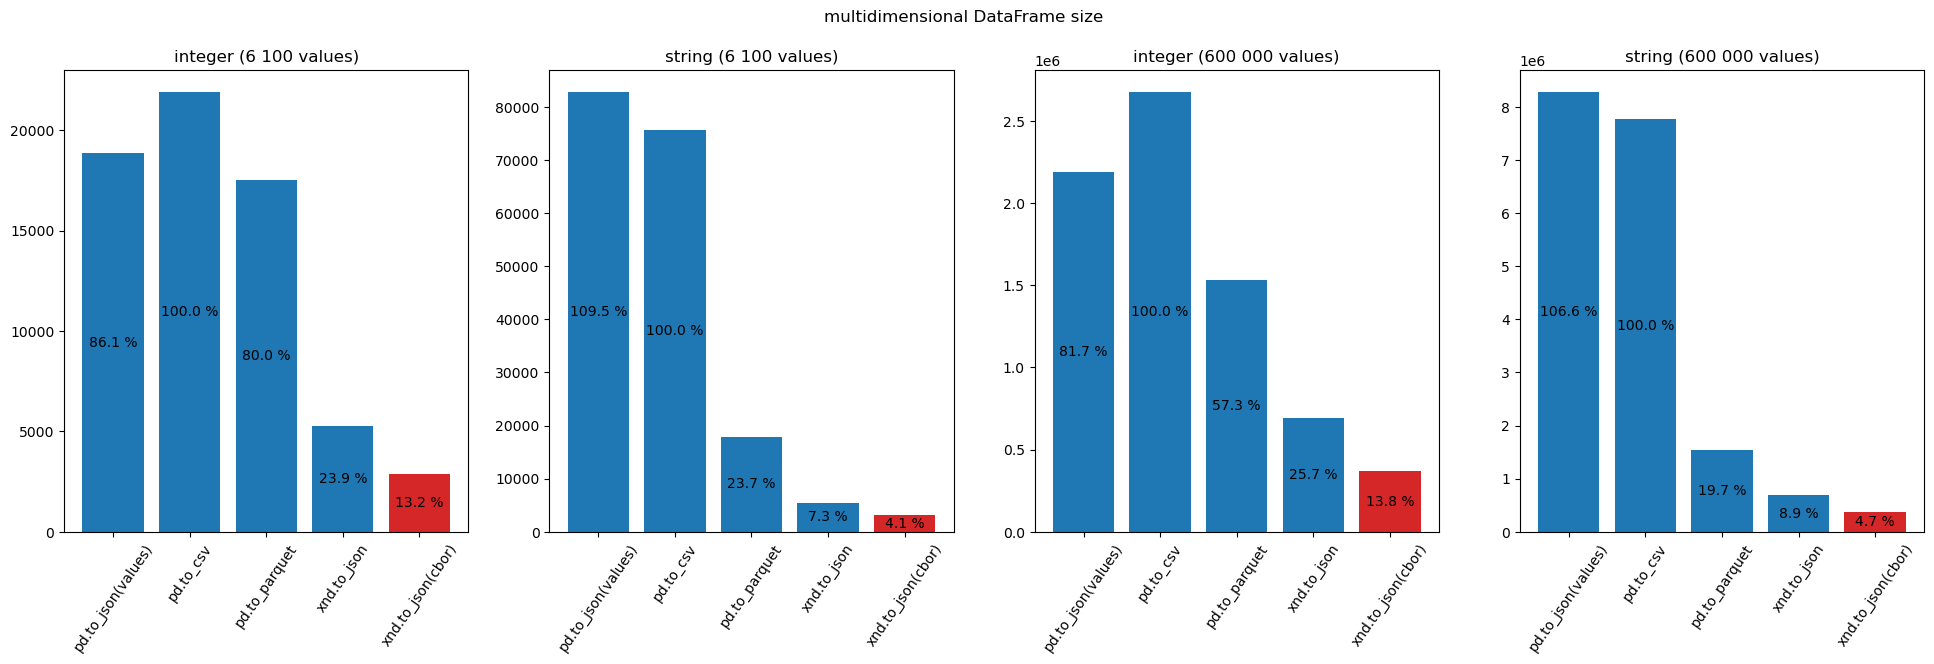

In [92]:
xnds = [Xdataset.from_xarray(xds) for xds in xdss]
sizes = [file_sizes(xnd) for xnd in xnds]
titles = ['integer (6 100 values)', 'string (6 100 values)', 'integer (600 000 values)', 'string (600 000 values)']
sizes_plot(sizes, titles, 'multidimensional DataFrame size')

## tree data

In [87]:
def data_int_str(size):
    arr = np.arange(2**size)
    data_int = [arr]
    data_str = [np.frompyfunc(str, 1, 1)(arr)]
    for i in range(size):
        arr = arr // 2
        data_int.append(arr)
        data_str.append(np.frompyfunc(str, 1, 1)(arr))
    field_names = ['col_' + str(i) for i in range(len(data_int))]
    return [data_int, data_str, field_names]   

#size1 = 9
#size2 = 15
size1 = 9
size2 = 14
data_set = data_int_str(size1)[:2] + data_int_str(size2)[:2]
names_set= [data_int_str(size1)[2]] * 2 + [data_int_str(size2)[2]] * 2

In [88]:
df_list = [pd.DataFrame({field: data for field, data in zip (field_names, data_list)}) for field_names, data_list in zip(names_set, data_set)]

df_list[2]

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,16379,8189,4094,2047,1023,511,255,127,63,31,15,7,3,1,0
16380,16380,8190,4095,2047,1023,511,255,127,63,31,15,7,3,1,0
16381,16381,8190,4095,2047,1023,511,255,127,63,31,15,7,3,1,0
16382,16382,8191,4095,2047,1023,511,255,127,63,31,15,7,3,1,0


In [89]:
xnds = [Xdataset.from_dataframe(df) for df in df_list]

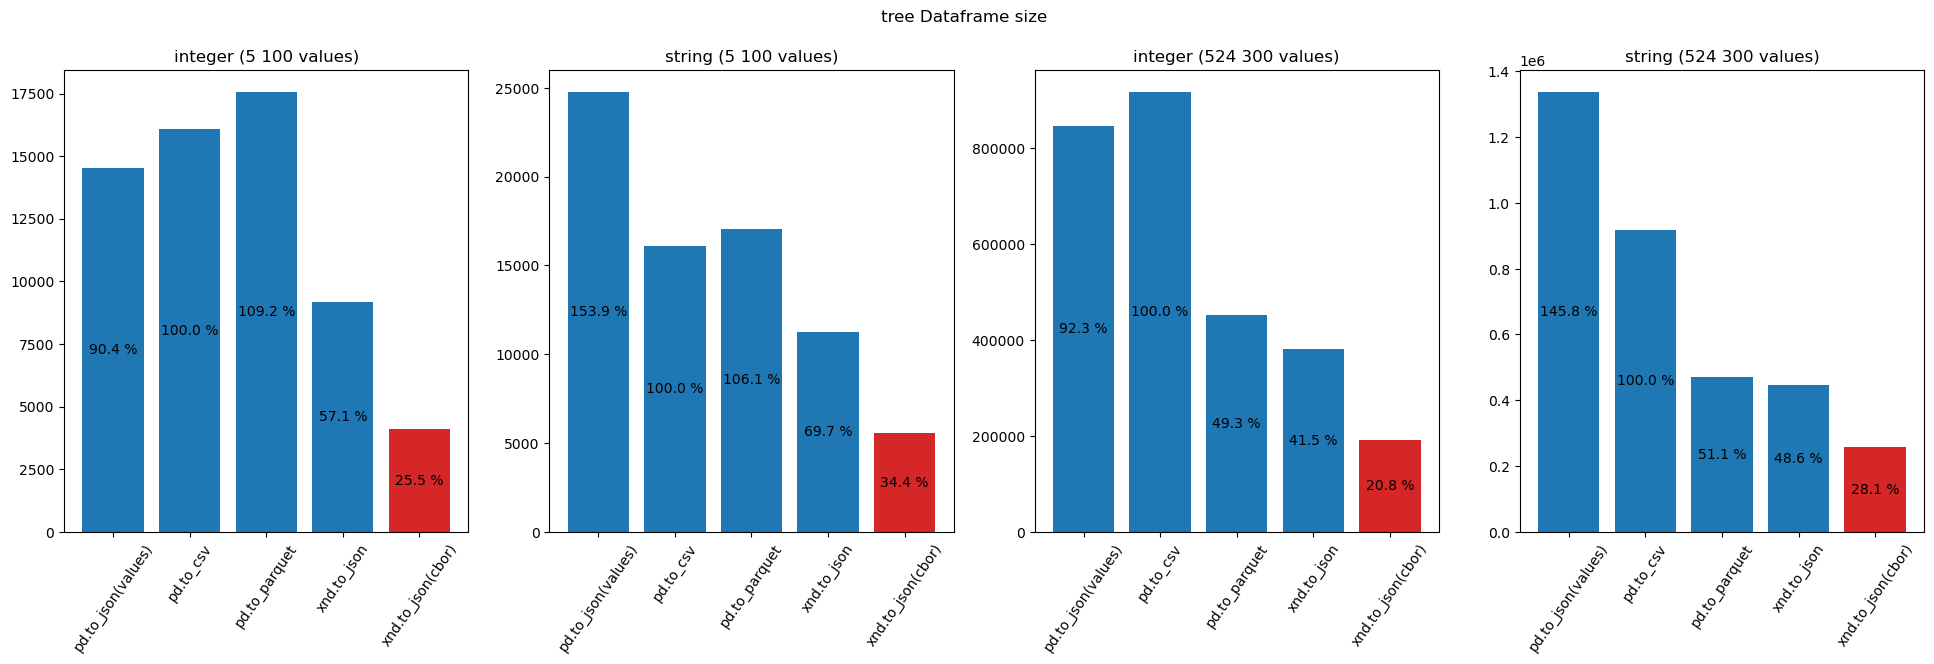

In [91]:
forma = [{name:'complete' for name in xnd.names[1:]} for xnd in xnds]
sizes = [file_sizes(xnd, form) for xnd, form in zip(xnds, forma)]
titles = ['integer (5 100 values)', 'string (5 100 values)', 'integer (524 300 values)', 'string (524 300 values)']
sizes_plot(sizes, titles, 'tree DataFrame size')

In [ ]:
df_int_tree = df_int_tree.sample(frac=1).reset_index(drop=True)
df_str_tree = df_str_tree.sample(frac=1).reset_index(drop=True)

In [ ]:
res_tree = []
for df in [df_int_tree, df_str_tree]:
    csv = df.to_csv()
    xnd = Xdataset.from_dataframe(df)
    jsn_full_txt = xnd.to_json(notype='all', encoded=True)
    jsn_full = xnd.to_json(notype='all')
    forma = {name:'complete' for name in xnd.names[1:]}
    jsn_comp_txt = xnd.to_json(notype='all', format=forma, encoded=True)
    jsn_comp = xnd.to_json(notype='all', format=forma)
    jsb_comp = cbor2.dumps(jsn_comp)
    
    res_tree.append([len(jsb_comp)/1024, len(jsn_comp_txt)/1024, len(jsn_full_txt)/1024, len(csv)/1024])
res_tree

In [ ]:
from time import time

df = df_int_tree
tim = [] 
tim.append(time())
csv = df.to_csv()
tim.append(time())
xnd = Xdataset.from_dataframe(df, distr=False)
tim.append(time())
jsn_full_txt = xnd.to_json(notype='all', encoded=True)
tim.append(time())
jsn_full = xnd.to_json(notype='all')
tim.append(time())
forma = {name:'complete' for name in xnd.names[1:]}
tim.append(time())
jsn_comp_txt = xnd.to_json(notype='all', format=forma, encoded=True)
tim.append(time())
jsn_comp = xnd.to_json(notype='all', format=forma)
tim.append(time())
jsb_comp = cbor2.dumps(jsn_comp)
tim.append(time())

dt = [tim[i+1] - tim[i] for i in range(len(tim)-1)]
dt
    

In [ ]:
from xconnector import PandasConnec
t0=time()
PandasConnec._ximport_analysis(df_int_tree, None, distr=True)
print(time()-t0)